
# Meme Virality Across Platforms: Notebook
**Group 23: Hanan F. Anderloni , Lingchen Chen, Feihong Tian, Akshara Bruno** 

**Research question:**  

## 1. Imports and global configuration

In [2]:
!pip install "numpy<2.0" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 14.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.1
    Uninstalling numpy-2.0.1:
      Successfully uninstalled numpy-2.0.1

[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Standard libraries
import os
import json
import math
import random
from pathlib import Path
from datetime import datetime

# Data & analysis
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Machine learning / embeddings / clustering
try:
    from sklearn.cluster import KMeans
    from sklearn.manifold import TSNE
except ImportError:
    print("scikit-learn is not installed. Install it to enable clustering and t-SNE visualizations.")

# Deep learning / CLIP (for image embeddings)
try:
    import torch
    from PIL import Image
    from transformers import CLIPProcessor, CLIPModel
except ImportError:
    print("torch / transformers / pillow not installed. Install them to enable image embeddings.")

# NLP
try:
    import nltk
    from nltk.sentiment import SentimentIntensityAnalyzer
except ImportError:
    print("nltk not installed. Install it to enable VADER sentiment analysis.")

# Global paths
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
IMAGES_DIR = PROJECT_ROOT / "images"

for p in [DATA_DIR, RAW_DIR, PROCESSED_DIR, IMAGES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /Users/chenlingchen/the social web



## 2. Data collection (overview)

We collect meme posts from:

- **Reddit** – using the Reddit API (e.g. PRAW or Pushshift-like interface).  
- **Bluesky** – using the ATProto API.

For each platform we aim to obtain:

- Post ID, author, timestamp  
- Caption / title text  
- Image URL(s)  
- Engagement statistics (upvotes / likes, comments / replies, reposts)  
- Platform indicator

In practice, the actual scraping code may be placed in a separate script to avoid  
API credential issues inside the notebook.


### 2.1 Reddit scraping 

In [16]:
import praw
import pandas as pd
from pathlib import Path
import datetime

# --- FILTER CONFIGURATION ---
# Start from 2005-02-01 00:00:00 UTC
start_dt = datetime.datetime(2005, 1, 1, tzinfo=datetime.timezone.utc)
TIMESTAMP_START = start_dt.timestamp()

RAW_DIR = Path("data/raw")
reddit_path = RAW_DIR / "reddit_memes_raw_2005_01_onward_variants.csv"

REDDIT_ENABLED = True

if REDDIT_ENABLED:
    reddit = praw.Reddit(
        client_id="Dhu5BDkroWpRBQ",
        client_secret="ojQeyIZ793E7I6fRFILOiLdJzdGNcg",
        user_agent="meme-research-notebook"
    )

    template_queries = {
    # Original 10 with MORE variants
    "change my mind": [
        '"change my mind"',
        'change-my-mind',
        'crowder table',
        '"change my mind meme"',
        'steven crowder table',
        'cmm table',
    ],
    "expanding brain": [
        '"expanding brain"',
        'galaxy brain',
        'expanding brain meme',
        '"brain expansion"',
        'increasing brain size',
        'evolving brain',
    ],
    "drake hotline bling": [
        '"drake hotline bling"',
        '"drake meme"',
        '"drakeposting"',
        'drake approves',
        'drake hotline',
        '"drake format"',
    ],
    "distracted boyfriend": [
        '"distracted boyfriend"',
        '"distracted bf"',
        '"man looking at other girl"',
        '"guy looking back"',
        'distracted boyfriend meme',
        '"cheating boyfriend meme"',
    ],
    "two-button choice": [
        '"two buttons"',
        '"red blue button"',
        '"two button dilemma"',
        'red or blue pill',
        '"button choice meme"',
        '"hard choice buttons"',
    ],
    "woman yelling at cat": [
        '"woman yelling at cat"',
        '"yelling at cat"',
        '"smudge the cat"',
        '"woman screaming cat"',
        'cat smug meme',
        '"angry woman cat"',
    ],
    "surprised pikachu": [
        '"surprised pikachu"',
        '"pikachu shocked"',
        '"pikachu surprise"',
        '"pikachu face"',
        'shocked pikachu meme',
        '"pikachu didnt know"',
    ],
    "mocking spongebob": [
        '"mocking spongebob"',
        '"spongebob mocking"',
        '"spongemock"',
        '"mocking sponge"',
        'alternating case spongebob',
        '"spongebob mock"',
    ],
    "this is fine": [
        '"this is fine"',
        '"this is fine dog"',
        '"burning room dog"',
        '"kc green dog"',
        'dog in fire meme',
        '"everything fine dog"',
    ],
    "is this a pigeon": [
        '"is this a pigeon"',
        '"pigeon guy"',
        '"butterfly meme guy"',
        '"is this a mood"',
        'renamon pigeon',
        '"pigeon confusion"',
    ],
    }

    TARGET_PER_TEMPLATE = 100
    MAX_RESULTS_PER_QUERY = 300  # per individual variant query
    current_time_iso = datetime.datetime.utcnow().isoformat()

    all_posts = []
    seen_ids = set()

    print("🚀 Starting Reddit data collection with query variants...")
    print(f"   Filtering for posts from {start_dt.isoformat()}")
    print("   No minimum score filter")
    print(f"   Target per canonical template: {TARGET_PER_TEMPLATE}")

    for template, queries in template_queries.items():
        print(f"\n=== Template: {template!r} ===")
        collected_for_template = 0

        for q in queries:
            if collected_for_template >= TARGET_PER_TEMPLATE:
                break

            print(f"  → Searching for variant query: {q!r}")
            for submission in reddit.subreddit("memes+funny+dankmemes").search(
                q,
                sort="new",
                time_filter="all",  # allow older than 1 year but filter in Python
                limit=MAX_RESULTS_PER_QUERY,
            ):
                if submission.id in seen_ids:
                    continue

                # Only enforce date now (no likes/score filter)
                if submission.created_utc < TIMESTAMP_START:
                    continue

                author_name = "[deleted]"
                if submission.author is not None:
                    author_name = submission.author.name

                all_posts.append({
                    "platform": "reddit",
                    "meme_template": template,  # canonical label
                    "search_query": q,          # actual query string used
                    "post_id": submission.id,
                    "author_handle": author_name,
                    "author_display": author_name,
                    "caption": submission.title,
                    "alt_text": "",
                    "image_url": submission.url,
                    "likes": submission.score,
                    "reposts": None,
                    "replies": submission.num_comments,
                    "created_at": datetime.datetime.fromtimestamp(
                        submission.created_utc, tz=datetime.timezone.utc
                    ).isoformat(),
                    "indexed_at": current_time_iso,
                    "post_url": f"https://www.reddit.com{submission.permalink}",
                    "image_path": None,
                    "image_width": None,
                    "image_height": None
                })

                seen_ids.add(submission.id)
                collected_for_template += 1

                if collected_for_template >= TARGET_PER_TEMPLATE:
                    print(f"   ✅ Reached {TARGET_PER_TEMPLATE} posts for {template!r}")
                    break

        print(f"   Collected {collected_for_template} posts for {template!r} after filtering.")

    reddit_df = pd.DataFrame(all_posts)
    RAW_DIR.mkdir(parents=True, exist_ok=True)
    reddit_df.to_csv(reddit_path, index=False)
    print(f"\n✅ Saved raw Reddit data to {reddit_path}.")
    print(f"Total posts collected after filtering: {len(reddit_df)}")

else:
    print("Reddit scraping disabled. Set REDDIT_ENABLED=True after configuring credentials.")

/var/folders/k5/sv2gpgh93ks3whjc1lnjkh380000gn/T/ipykernel_81170/84576829.py:109: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time_iso = datetime.datetime.utcnow().isoformat()


🚀 Starting Reddit data collection with query variants...
   Filtering for posts from 2005-01-01T00:00:00+00:00
   No minimum score filter
   Target per canonical template: 100

=== Template: 'change my mind' ===
  → Searching for variant query: '"change my mind"'
   ✅ Reached 100 posts for 'change my mind'
   Collected 100 posts for 'change my mind' after filtering.

=== Template: 'expanding brain' ===
  → Searching for variant query: '"expanding brain"'
  → Searching for variant query: 'galaxy brain'
   ✅ Reached 100 posts for 'expanding brain'
   Collected 100 posts for 'expanding brain' after filtering.

=== Template: 'drake hotline bling' ===
  → Searching for variant query: '"drake hotline bling"'
  → Searching for variant query: '"drake meme"'
   ✅ Reached 100 posts for 'drake hotline bling'
   Collected 100 posts for 'drake hotline bling' after filtering.

=== Template: 'distracted boyfriend' ===
  → Searching for variant query: '"distracted boyfriend"'
  → Searching for variant

### Maybe delete if it's not working? 2.1 Reddit scraping skeleton (to run once, offline)

In [4]:

# NOTE: This is a placeholder illustrating how Reddit data could be collected.
# In the final version you may move this into a separate script and run it once,
# then store the results as CSV(s) in data/raw or data/processed.

REDDIT_ENABLED = False  # set to True when you configure credentials

if REDDIT_ENABLED:
    import praw  # pip install praw

    reddit = praw.Reddit(
        client_id="YOUR_CLIENT_ID",
        client_secret="YOUR_CLIENT_SECRET",
        user_agent="meme-research-notebook"
    )

    meme_templates = ["change my mind", "expanding brain"]  # extend as needed
    posts = []

    for query in meme_templates:
        for submission in reddit.subreddit("memes+funny+dankmemes").search(query, limit=500):
            posts.append({
                "platform": "reddit",
                "template_query": query,
                "id": submission.id,
                "subreddit": submission.subreddit.display_name,
                "title": submission.title,
                "selftext": submission.selftext,
                "url": submission.url,
                "created_utc": submission.created_utc,
                "score": submission.score,
                "num_comments": submission.num_comments
            })

    reddit_df = pd.DataFrame(posts)
    RAW_DIR.mkdir(parents=True, exist_ok=True)
    reddit_path = RAW_DIR / "reddit_memes_raw.csv"
    reddit_df.to_csv(reddit_path, index=False)
    print("Saved raw Reddit data to", reddit_path)
else:
    print("Reddit scraping disabled. Set REDDIT_ENABLED=True after configuring credentials.")


Reddit scraping disabled. Set REDDIT_ENABLED=True after configuring credentials.


### 2.2 Bluesky scraping skeleton (to run once, offline)

In [ ]:
import sys
!{sys.executable} -m pip install atproto

In [13]:
#Step 1: log in
print("Trying to login...")

from atproto import Client

client = Client()

# Try both options
identifiers = [
    "feih16.bsky.social",  # handle without @
    "tianfh616@gmail.com",  # your email if handle doesn't work
    "@feih16.bsky.social",  # handle with @ (less likely to work)
]

for identifier in identifiers:
    print(f"\nTrying to login with: {identifier}")
    try:
        session = client.login(identifier, "3eqo-vpdc-u7u5-q47d")
        print(f"✅ SUCCESS with {identifier}")
        print(f"   Logged in as: {session.handle}")
        break
    except Exception as e:
        print(f"❌ Failed: {e}")

# Now that we're logged in, let's understand post structure
from atproto import Client, models

# We already have a logged-in client 
# Let's test the search with the authenticated client
params = models.AppBskyFeedSearchPosts.Params(
    q="change my mind",
    limit=3  # Get 3 posts to see variety
)

feed = client.app.bsky.feed.search_posts(params)

print(f"\n📊 Found {len(feed.posts)} posts for 'change my mind'")

'''
# explore post structure
for i, post in enumerate(feed.posts):
    print(f"\n{'='*60}")
    print(f"POST {i+1}")
    print('='*60)
    
    # Basic info
    print(f"URI (unique ID): {post.uri}")
    print(f"Author: {post.author.handle}")
    
    # Text content
    if hasattr(post, 'record'):
        text = post.record.text[:150]
        print(f"Text: {text}..." if len(post.record.text) > 150 else f"Text: {post.record.text}")
        print(f"Created at: {post.record.created_at}")
    
    # Check for images
    has_images = False
    if hasattr(post, 'embed') and hasattr(post.embed, 'images'):
        image_count = len(post.embed.images)
        print(f"Has images: YES ({image_count} images)")
        for img_idx, img in enumerate(post.embed.images[:2]):  # Show first 2
            if hasattr(img, 'image'):
                print(f"  Image {img_idx+1}: {img.image}")
        has_images = True
    else:
        print("Has images: NO")
    
    # Engagement metrics
    print(f"Likes: {getattr(post, 'like_count', 0)}")
    print(f"Reposts: {getattr(post, 'repost_count', 0)}")
    print(f"Replies: {getattr(post, 'reply_count', 0)}")
    
    # Quick summary for our project
    print(f"\n✅ FOR OUR PROJECT: This post has {'images' if has_images else 'NO images'} and text for analysis")
    '''

Trying to login...

Trying to login with: feih16.bsky.social
✅ SUCCESS with feih16.bsky.social
   Logged in as: feih16.bsky.social

📊 Found 3 posts for 'change my mind'


'\n# explore post structure\nfor i, post in enumerate(feed.posts):\n    print(f"\n{\'=\'*60}")\n    print(f"POST {i+1}")\n    print(\'=\'*60)\n    \n    # Basic info\n    print(f"URI (unique ID): {post.uri}")\n    print(f"Author: {post.author.handle}")\n    \n    # Text content\n    if hasattr(post, \'record\'):\n        text = post.record.text[:150]\n        print(f"Text: {text}..." if len(post.record.text) > 150 else f"Text: {post.record.text}")\n        print(f"Created at: {post.record.created_at}")\n    \n    # Check for images\n    has_images = False\n    if hasattr(post, \'embed\') and hasattr(post.embed, \'images\'):\n        image_count = len(post.embed.images)\n        print(f"Has images: YES ({image_count} images)")\n        for img_idx, img in enumerate(post.embed.images[:2]):  # Show first 2\n            if hasattr(img, \'image\'):\n                print(f"  Image {img_idx+1}: {img.image}")\n        has_images = True\n    else:\n        print("Has images: NO")\n    \n    # 

In [ ]:
# Step 2: Enhanced collection for all 10 meme templates with corrected image extraction
import time
import pandas as pd
from datetime import datetime, timezone, timedelta
import sys

print("🎯 COMPREHENSIVE MEME DATA COLLECTION")
print("=====================================")
print(f"Collecting 10 meme templates at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# research constraints
SINCE_DATE = datetime(2024, 2, 1, tzinfo=timezone.utc)  # Step 1: only keep posts since Feb 1, 2024
START_DATE = datetime(2024, 2, 1) 
END_DATE = datetime.now()         
WINDOW_DAYS = 7                    
MIN_LIKES = 100  # Step 2: like threshold 

# All 10 meme templates
ALL_MEME_TEMPLATES = [
    "change my mind",
    "drake hotline bling", 
    "distracted boyfriend",
    "two button choice",
    "expanding brain",
    "woman yelling at cat",
    "surprised pikachu",
    "mocking spongebob",
    "this is fine",
    "is this a pigeon"
]

# Alternative search queries for each template
TEMPLATE_SEARCH_VARIANTS = {
    "change my mind": ["change my mind meme", "changemymind", "#changemymind"],
    "drake hotline bling": ["drake hotline bling meme", "drake meme", "drake reaction"],
    "distracted boyfriend": ["distracted boyfriend meme", "distracted boyfriend", "looking at other girl"],
    "two button choice": ["two button meme", "two buttons", "which button"],
    "expanding brain": ["expanding brain meme", "brain expanding", "5d chess"],
    "woman yelling at cat": ["woman yelling at cat meme", "yelling cat meme", "woman cat restaurant"],
    "surprised pikachu": ["surprised pikachu meme", "pikachu surprised", "pikachu face"],
    "mocking spongebob": ["mocking spongebob meme", "spongebob mock", "mockingspongebob"],
    "this is fine": ["this is fine meme", "dog burning house", "everything is fine"],
    "is this a pigeon": ["is this a pigeon meme", "butterfly meme", "is this a butterfly"]
}

all_meme_data = []
unique_post_ids = set()  # To avoid duplicates

# Create processed directory if it doesn't exist
from pathlib import Path
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

def extract_image_url(embed_image):
    """Extract image URL from Bluesky ViewImage object with multiple fallbacks"""
    try:
        # Method 1: Check for fullsize attribute (newer structure)
        if hasattr(embed_image, 'fullsize'):
            return str(embed_image.fullsize)
        
        # Method 2: Check for image attribute with ref.link (older structure)
        if hasattr(embed_image, 'image'):
            if hasattr(embed_image.image, 'ref') and hasattr(embed_image.image.ref, 'link'):
                return str(embed_image.image.ref.link)
        
        # Method 3: Check for thumb attribute and convert to fullsize
        if hasattr(embed_image, 'thumb'):
            thumb_url = str(embed_image.thumb)
            # Try to convert thumbnail URL to fullsize
            if 'feed_thumbnail' in thumb_url:
                return thumb_url.replace('feed_thumbnail', 'feed_fullsize')
            # Try other common thumbnail to fullsize conversions
            if '/thumb/' in thumb_url:
                return thumb_url.replace('/thumb/', '/fullsize/')
            # Just return the thumb URL as fallback
            return thumb_url
        
        # Method 4: Check for direct link in various attributes
        for attr in ['link', 'url', 'href', 'src']:
            if hasattr(embed_image, attr):
                url = getattr(embed_image, attr)
                if url and isinstance(url, str) and url.startswith('http'):
                    return url
        
        # Method 5: Try to get from the object's dictionary representation
        if hasattr(embed_image, '__dict__'):
            for key, value in embed_image.__dict__.items():
                if isinstance(value, str) and value.startswith('http') and any(ext in value.lower() for ext in ['.jpg', '.jpeg', '.png', '.gif', '.webp']):
                    return value
        
        print(f"Could not extract image URL from: {dir(embed_image)[:10]}...")
        return None
        
    except Exception as e:
        print(f"Error extracting image URL: {e}")
        return None

for template in ALL_MEME_TEMPLATES:
    print(f"\nSearching for: '{template}'")
    print("-" * 40)
    
    template_posts = []
    search_queries = TEMPLATE_SEARCH_VARIANTS.get(template, [template, f"{template} meme"])
    
    for search_idx, search_query in enumerate(search_queries[:3]):  # Try first 3 variations
        print(f"  Query {search_idx+1}: '{search_query}'")
        
        try:
            total_collected_query = 0
            
            # time slice loop
            window_start = START_DATE
            
            while window_start < END_DATE:
                # calculate current window end time
                window_end = window_start + timedelta(days=WINDOW_DAYS)
                if window_end > END_DATE:
                    window_end = END_DATE
                
                # transform API needed format(for example: 2024-02-01T00:00:00Z)
                since_str = window_start.isoformat() + "Z"
                until_str = window_end.isoformat() + "Z"
                
                print(f"Processing Window: {window_start.date()} -> {window_end.date()}")
                
                cursor = None
                page_num = 1  # calculate page number for logging
                
                # --- pagination loop  ---
                while True:
                    try:
                        params = models.AppBskyFeedSearchPosts.Params(
                            q=search_query,
                            limit=25,       # Max per request (Bluesky limit)
                            cursor=cursor,
                            since=since_str, 
                            until=until_str, 
                            sort="latest"
                        )
                        
                        feed = client.app.bsky.feed.search_posts(params)
                        
                        if not feed or not hasattr(feed, 'posts') or not feed.posts:
                            break
                        
                        page_collected = 0
                        for post in feed.posts:
                            # Skip if we've seen this post before
                            if post.uri in unique_post_ids:
                                continue
                            
                            # --- date doublecheck (optional) ---
                            created_raw = getattr(post.record, 'created_at', '')
                            
                            #  get likes once & filter
                            likes = getattr(post, 'like_count', 0)
                            if likes < MIN_LIKES:
                                continue
                                
                            # Check if post has images
                            has_image = (hasattr(post, 'embed') and 
                                        hasattr(post.embed, 'images') and 
                                        post.embed.images and 
                                        len(post.embed.images) > 0)
                            
                            if has_image:
                                try:
                                    # Extract image URL
                                    image_url = extract_image_url(post.embed.images[0])
                                    
                                    if image_url:
                                        # Get alt text
                                        alt_text = ""
                                        if hasattr(post.embed.images[0], 'alt'):
                                            alt_text = post.embed.images[0].alt
                                        
                                        # Extract data for analysis
                                        post_data = {
                                            'platform': 'bluesky',
                                            'meme_template': template,
                                            'search_query': search_query,
                                            'post_id': post.uri,
                                            'author_handle': post.author.handle,
                                            'author_display': getattr(post.author, 'display_name', ''),
                                            'caption': getattr(post.record, 'text', ''),
                                            'alt_text': alt_text,
                                            'image_url': image_url,
                                            'likes': likes,
                                            'reposts': getattr(post, 'repost_count', 0),
                                            'replies': getattr(post, 'reply_count', 0),
                                            'created_at': created_raw,
                                            'indexed_at': getattr(post, 'indexed_at', ''),
                                            'post_url': f"https://bsky.app/profile/{post.author.handle}/post/{post.uri.split('/')[-1]}",
                                            'collection_timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                                        }
                                        
                                        template_posts.append(post_data)
                                        unique_post_ids.add(post.uri)
                                        page_collected += 1
                                        total_collected_query += 1
                                
                                except Exception as e:
                                    print(f"       Error processing image: {e}")
                                    continue
                        
                        print(f"      Page {page_num}: Found {len(feed.posts)} posts, {page_collected} kept")
                        
                        # Check for next page within this time window
                        if hasattr(feed, 'cursor') and feed.cursor:
                            cursor = feed.cursor
                            page_num += 1
                            time.sleep(0.3)  # Rate limiting
                        else:
                            break # No cursor, done with this window
                            
                    except Exception as e:
                        print(f"       API Error in window {window_start.date()}: {e}")
                        time.sleep(2) # Error backoff
                        break
                
                # Move to next time window
                window_start = window_end
                time.sleep(0.5) # Courtesy sleep between windows
            
            print(f"    Total from this query: {total_collected_query} new meme posts")
            
        except Exception as e:
            print(f"    Error with query '{search_query}': {e}")
            continue
        
        time.sleep(1)  # Rate limiting between queries
    
    # Add to overall collection
    all_meme_data.extend(template_posts)
    print(f" Total for '{template}': {len(template_posts)} meme posts")
    
    # Save intermediate results
    if template_posts:
        template_df = pd.DataFrame(template_posts)
        # Clean filename
        safe_template_name = "".join([c for c in template if c.isalpha() or c.isdigit() or c==' ']).rstrip()
        template_file = PROCESSED_DIR / f"memes_{safe_template_name.replace(' ', '_')}_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
        template_df.to_csv(template_file, index=False, encoding='utf-8')
        print(f" Saved template data to: {template_file}")
# Create final DataFrame
if all_meme_data:
    df_comprehensive = pd.DataFrame(all_meme_data)


    print(f"\n{'='*60}")
    print(" COLLECTION COMPLETE!")
    print(f"{'='*60}")
    print(f"Total meme posts collected: {len(df_comprehensive)}")
    print(f"Unique posts: {len(unique_post_ids)}")
    
    # Save comprehensive dataset
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    output_file = PROCESSED_DIR / f"all_memes_comprehensive_{timestamp}.csv"
    df_comprehensive.to_csv(output_file, index=False, encoding='utf-8')
    
    print(f"\n SAVED COMPREHENSIVE DATASET:")
    print(f"   {output_file}")
    
    # Show statistics
    print(f"\n BREAKDOWN BY TEMPLATE:")
    template_counts = df_comprehensive['meme_template'].value_counts()
    for template, count in template_counts.items():
        print(f"   {template}: {count} posts")
    
    print(f"\n ENGAGEMENT STATISTICS:")
    print(f"   Average likes: {df_comprehensive['likes'].mean():.1f}")
    print(f"   Average reposts: {df_comprehensive['reposts'].mean():.1f}")
    print(f"   Average replies: {df_comprehensive['replies'].mean():.1f}")
    
    print(f"\n SAMPLE DATA (first 3 rows):")
    print(df_comprehensive[['meme_template', 'author_handle', 'caption', 'likes', 'reposts']].head(3).to_string(index=False))
    
    # Additional analysis
    print(f"\n ADDITIONAL INSIGHTS:")
    print(f"   Posts with images: {len(df_comprehensive)}")
    print(f"   Unique authors: {df_comprehensive['author_handle'].nunique()}")
    print(f"   Date range: {df_comprehensive['created_at'].min()} to {df_comprehensive['created_at'].max()}")
    
else: print("No data collected. Need to adjust search strategy.")

## to be deleted

In [ ]:
# Step 3: Download images for all collected memes
def download_all_meme_images(df):
    """Download images for comprehensive dataset"""
    import requests
    from PIL import Image
    import io
    
    print("\n📥 DOWNLOADING ALL MEME IMAGES")
    print("=" * 60)
    
    # Create images directory
    IMAGES_DIR = PROJECT_ROOT / "images"
    IMAGES_DIR.mkdir(exist_ok=True)
    
    download_count = 0
    error_count = 0
    df = df.copy()  # Work on a copy
    
    for idx, row in df.iterrows():
        try:
            # Skip if no image URL
            if not row['image_url'] or pd.isna(row['image_url']):
                error_count += 1
                continue
            
            # Create organized folder structure
            template_folder = row['meme_template'].replace(' ', '_').lower()[:20]
            template_dir = IMAGES_DIR / template_folder
            template_dir.mkdir(exist_ok=True)
            
            # Create descriptive filename
            author_safe = row['author_handle'].replace('.bsky.social', '').replace('.', '_')[:15]
            date_part = row['created_at'][:10] if row['created_at'] else 'unknown'
            filename = f"{template_folder}_{author_safe}_{date_part}_{idx}.jpg"
            filepath = template_dir / filename
            
            # Skip if already downloaded
            if filepath.exists():
                df.at[idx, 'image_path'] = str(filepath)
                download_count += 1
                continue
            
            # Download image
            print(f"  Downloading {template_folder}/{filename}...")
            
            headers = {
                'User-Agent': 'Meme Research Project v1.0 (Academic)',
                'Accept': 'image/*'
            }
            
            response = requests.get(row['image_url'], headers=headers, timeout=20)
            
            if response.status_code == 200:
                # Save image
                with open(filepath, 'wb') as f:
                    f.write(response.content)
                
                # Verify it's a valid image
                try:
                    img = Image.open(filepath)
                    img.verify()  # Verify it's a valid image
                    
                    # Store metadata
                    df.at[idx, 'image_path'] = str(filepath)
                    df.at[idx, 'image_width'], df.at[idx, 'image_height'] = img.size
                    df.at[idx, 'image_format'] = img.format
                    
                    download_count += 1
                    print(f"    ✓ {img.size} ({img.format})")
                    
                except Exception as img_error:
                    print(f"    ⚠️ Invalid image: {img_error}")
                    filepath.unlink(missing_ok=True)
                    error_count += 1
            
            else:
                print(f"    ❌ HTTP {response.status_code}")
                error_count += 1
            
            # Rate limiting
            time.sleep(0.2)
            
        except Exception as e:
            print(f"  ❌ Error row {idx}: {str(e)[:100]}")
            error_count += 1
    
    return df, download_count, error_count

# Download images if we have data
if 'df_comprehensive' in locals() and not df_comprehensive.empty:
    print(f"\n🖼️  Starting image download for {len(df_comprehensive)} posts...")
    
    df_with_images, downloaded, errors = download_all_meme_images(df_comprehensive)
    
    print(f"\n📊 IMAGE DOWNLOAD SUMMARY:")
    print(f"   Successfully downloaded: {downloaded}")
    print(f"   Errors: {errors}")
    print(f"   Success rate: {downloaded/(downloaded+errors)*100:.1f}%")
    
    # Save dataset with image paths
    final_output = PROCESSED_DIR / f"all_memes_with_images_{timestamp}.csv"
    df_with_images.to_csv(final_output, index=False, encoding='utf-8')
    
    print(f"\n💾 FINAL DATASET SAVED TO:")
    print(f"   {final_output}")
    
    # Create a summary report
    summary_file = PROCESSED_DIR / f"collection_summary_{timestamp}.txt"
    with open(summary_file, 'w') as f:
        f.write("MEME DATA COLLECTION SUMMARY\n")
        f.write("=" * 40 + "\n\n")
        f.write(f"Collection date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total posts collected: {len(df_with_images)}\n")
        f.write(f"Images successfully downloaded: {downloaded}\n")
        f.write(f"Download errors: {errors}\n\n")
        
        f.write("BY TEMPLATE:\n")
        for template, count in df_with_images['meme_template'].value_counts().items():
            f.write(f"  {template}: {count}\n")
    
    print(f"\n📄 Summary report saved to: {summary_file}")

## 3. Load processed data

In [ ]:

# In the final project, you will provide cleaned CSV files in data/processed.
# Here we load them; if they do not exist yet, we show an empty DataFrame
# so that the notebook can still run without errors.

reddit_path = PROCESSED_DIR / "reddit_memes.csv"
bluesky_path = PROCESSED_DIR / "bluesky_memes.csv"

if reddit_path.exists():
    reddit_df = pd.read_csv(reddit_path)
else:
    reddit_df = pd.DataFrame()
    print("WARNING: reddit_memes.csv not found in data/processed. Using empty DataFrame.")

if bluesky_path.exists():
    bluesky_df = pd.read_csv(bluesky_path)
else:
    bluesky_df = pd.DataFrame()
    print("WARNING: bluesky_memes.csv not found in data/processed. Using empty DataFrame.")

print("Reddit shape:", reddit_df.shape)
print("Bluesky shape:", bluesky_df.shape)



## 4. Data cleaning and harmonization

Goals:

- Merge Reddit and Bluesky into a unified schema.  
- Standardize timestamp format.  
- Create unified fields for:
  - `caption` (title/text)  
  - `image_url`  
  - `likes`, `comments`, `shares` (or platform equivalents)  
  - `platform`  

We also filter to posts that actually contain images and belong to the meme templates of interest.


In [1]:

# Example harmonization skeleton

def unify_reddit(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out["platform"] = "reddit"
    out["caption"] = out["title"].fillna("") + " " + out["selftext"].fillna("")
    out["image_url"] = out["url"]
    out["likes"] = out["score"]
    out["comments"] = out["num_comments"]
    out["shares"] = np.nan  # Reddit has no explicit "shares"
    out["created_at"] = pd.to_datetime(out["created_utc"], unit="s")
    return out[["platform", "caption", "image_url", "likes", "comments", "shares", "created_at"]]

def unify_bluesky(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out["platform"] = "bluesky"
    out["caption"] = out["text"]
    out["image_url"] = out.get("image_urls", "")
    out["likes"] = out.get("like_count", np.nan)
    out["comments"] = out.get("reply_count", np.nan)
    out["shares"] = out.get("repost_count", np.nan)
    out["created_at"] = pd.to_datetime(out["created_at"])
    return out[["platform", "caption", "image_url", "likes", "comments", "shares", "created_at"]]

unified_frames = []
for df, fn in [(reddit_df, unify_reddit), (bluesky_df, unify_bluesky)]:
    unified_frames.append(fn(df))

full_df = pd.concat(unified_frames, ignore_index=True) if unified_frames else pd.DataFrame()
print("Unified dataset shape:", full_df.shape)
full_df.head()


NameError: name 'pd' is not defined

## 5. Calculate engagement metric + graphs (monthly)

## Reddit

In [19]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data/raw/reddit_memes_raw_2005_01_onward_variants.csv")

# -----------------------------
# 1. Clean & convert data types
# -----------------------------

df["likes"] = pd.to_numeric(df["likes"], errors="coerce")
df["replies"] = pd.to_numeric(df["replies"], errors="coerce")
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["month"] = df["created_at"].dt.to_period("M").astype(str)

# -----------------------------
# 2. FILTER: only Feb 2024 onward
# -----------------------------
df = df[df["month"] >= "2024-02"]

# -----------------------------
# 3. Compute Weighted Engagement
# -----------------------------
df["engagement"] = df["likes"] + 2 * df["replies"]

# -----------------------------
# 4. Group by Template × Month × Platform
# -----------------------------
monthly = (
    df.groupby(["platform", "meme_template", "month"])
      .agg(
          total_engagement = ("engagement", "sum"),
          avg_engagement   = ("engagement", "mean"),
          post_count       = ("engagement", "count"),
          total_likes      = ("likes", "sum"),
          total_replies    = ("replies", "sum")
      )
      .reset_index()
)

monthly.to_csv("reddit_monthly_template_summary.csv", index=False)
monthly.head()

/var/folders/k5/sv2gpgh93ks3whjc1lnjkh380000gn/T/ipykernel_81170/2838954769.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M").astype(str)


,platform,meme_template,month,total_engagement,avg_engagement,post_count,total_likes,total_replies
0,reddit,change my mind,2024-02,841,280.333333,3,599,121
1,reddit,change my mind,2024-04,2231,1115.500000,2,2091,70
2,reddit,change my mind,2024-05,233,38.833333,6,135,49
3,reddit,change my mind,2024-07,11550,2887.500000,4,10232,659
4,reddit,change my mind,2024-08,34,34.000000,1,14,10


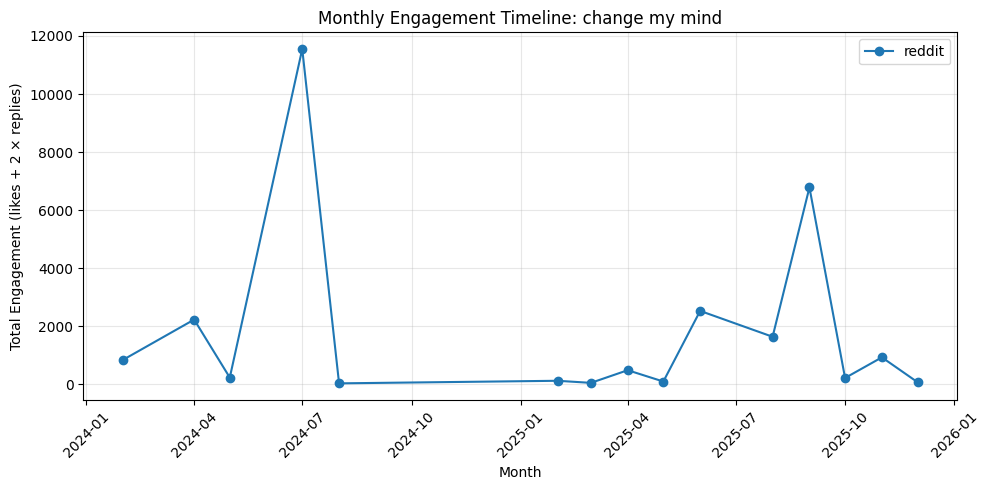

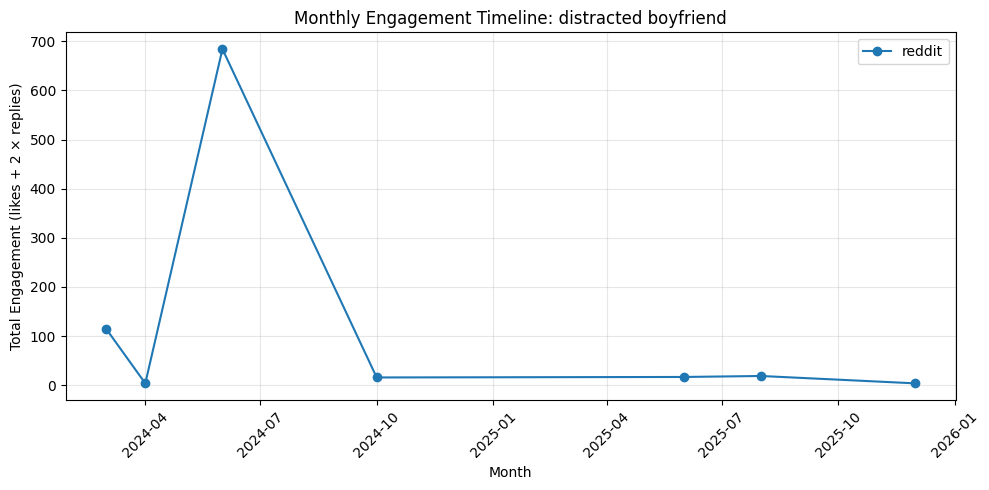

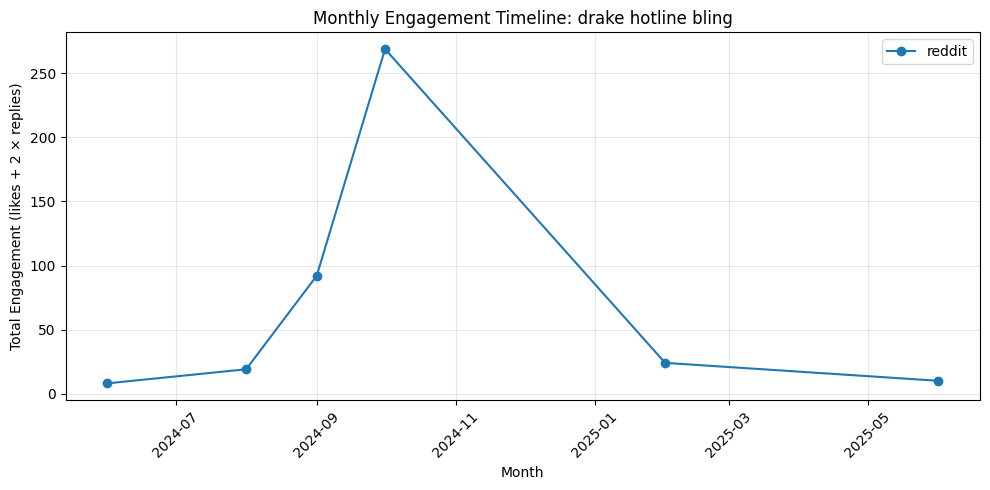

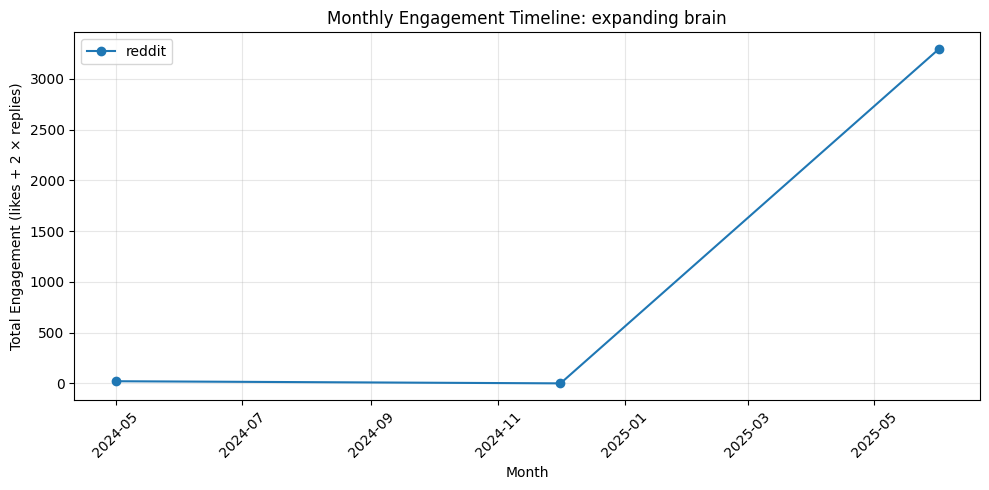

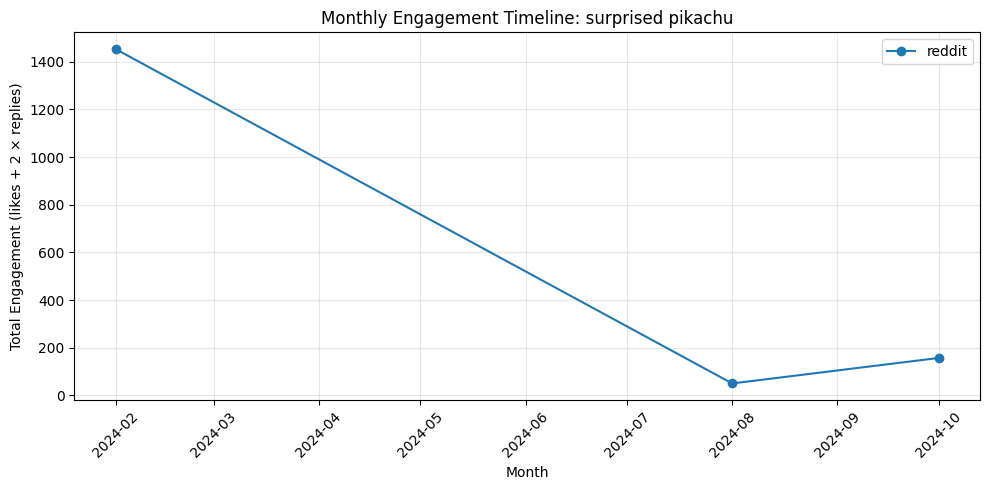

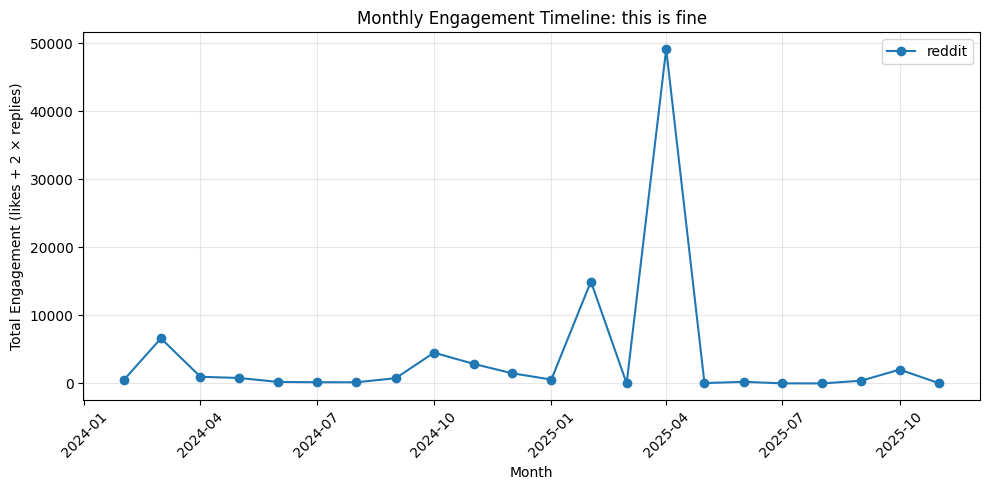

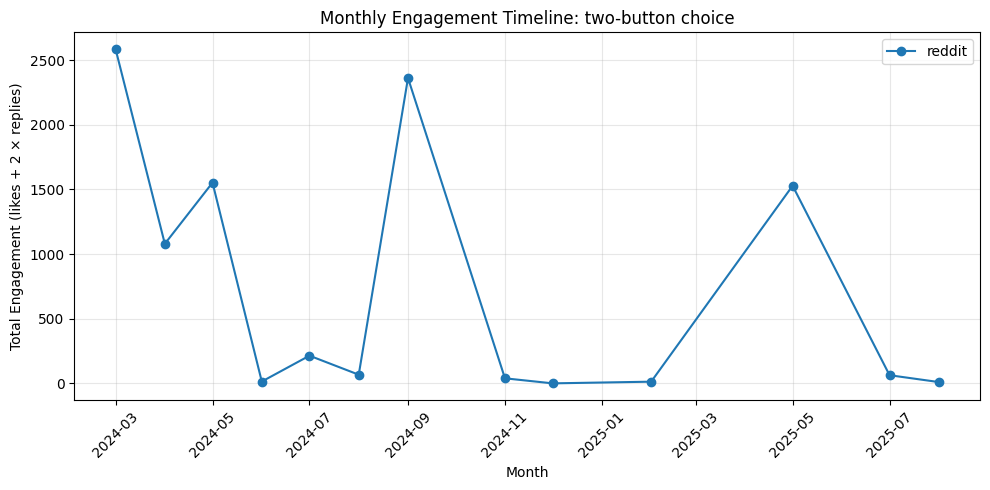

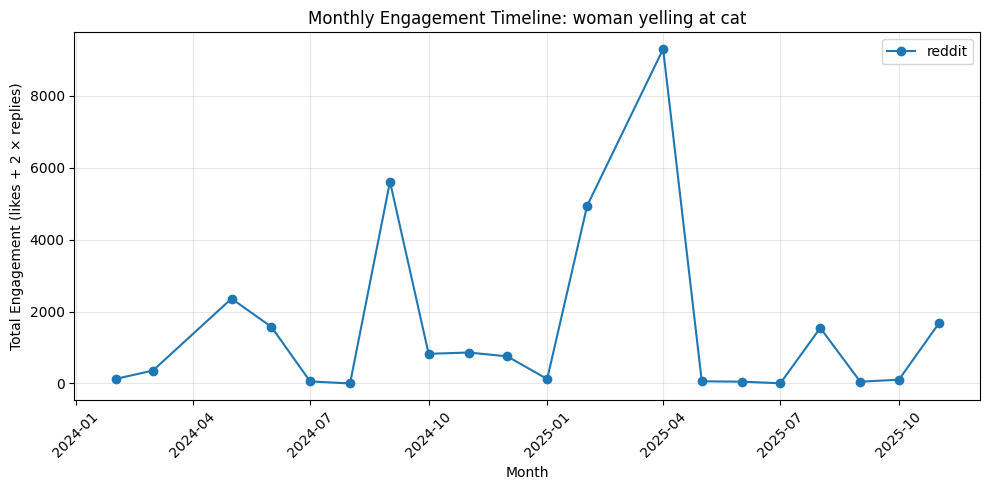

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your monthly summary file
monthly = pd.read_csv("reddit_monthly_template_summary.csv")

# Ensure month is sorted correctly
monthly["month"] = pd.to_datetime(monthly["month"])

# -----------------------------
# FILTER: Keep data from Feb 2024 onward
# -----------------------------
monthly = monthly[monthly["month"] >= "2024-02-01"]

# Get the unique templates
templates = monthly["meme_template"].unique()

# Loop through templates and create a plot for each one
for template in templates:
    subset = monthly[monthly["meme_template"] == template].sort_values("month")

    plt.figure(figsize=(10, 5))

    # Plot separately for each platform
    for platform in subset["platform"].unique():
        platform_data = subset[subset["platform"] == platform]

        plt.plot(
            platform_data["month"],
            platform_data["total_engagement"],
            marker="o",
            label=platform,
        )

    plt.title(f"Monthly Engagement Timeline: {template}")
    plt.xlabel("Month")
    plt.ylabel("Total Engagement (likes + 2 × replies)")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Save each figure
    plt.savefig(f"images/plots/reddit_timeline_{template.replace(' ', '_')}.png", dpi=300)

    plt.show()


## Bluesky

### 5.1 Metric 

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("merged.csv")

# -----------------------------
# 1. Clean & convert data types
# -----------------------------

# Ensure numeric types
df["likes"] = pd.to_numeric(df["likes"], errors="coerce")
df["replies"] = pd.to_numeric(df["replies"], errors="coerce")

# Convert created_at to datetime
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# Extract Year-Month (YYYY-MM)
df["month"] = df["created_at"].dt.to_period("M").astype(str)

# -----------------------------
# 2. Compute Weighted Engagement
# -----------------------------
df["engagement"] = df["likes"] + 2 * df["replies"]

# -----------------------------
# 3. Group by Template × Month × Platform
# -----------------------------
monthly = (
    df.groupby(["platform", "meme_template", "month"])
      .agg(
          total_engagement = ("engagement", "sum"),
          avg_engagement   = ("engagement", "mean"),
          post_count       = ("engagement", "count"),
          total_likes      = ("likes", "sum"),
          total_replies    = ("replies", "sum")
      )
      .reset_index()
    
)

# -----------------------------
# 4. Save monthly summary
# -----------------------------
monthly.to_csv("monthly_template_summary.csv", index=False)

monthly.head()


/var/folders/1_/s2ydmt055zq0z6vwbbn0mm8c0000gn/T/ipykernel_66838/1313840945.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_at"].dt.to_period("M").astype(str)


,platform,meme_template,month,total_engagement,avg_engagement,post_count,total_likes,total_replies
0,bluesky,distracted boyfriend,2024-02,757.0,252.333333,3,751.0,3.0
1,bluesky,distracted boyfriend,2024-03,417.0,208.500000,2,399.0,9.0
2,bluesky,distracted boyfriend,2024-04,346.0,173.000000,2,340.0,3.0
3,bluesky,distracted boyfriend,2024-05,384.0,192.000000,2,380.0,2.0
4,bluesky,distracted boyfriend,2024-06,1234.0,411.333333,3,1178.0,28.0


### 5.2 Graphs

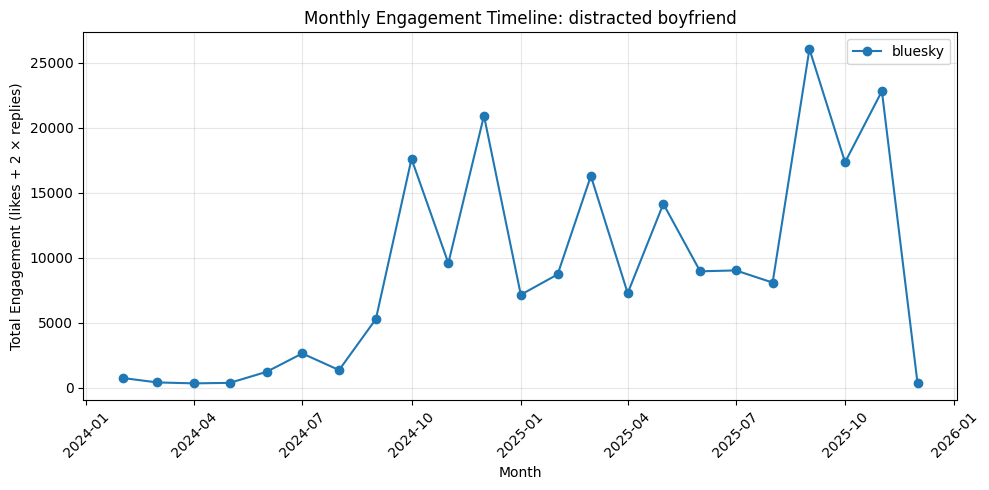

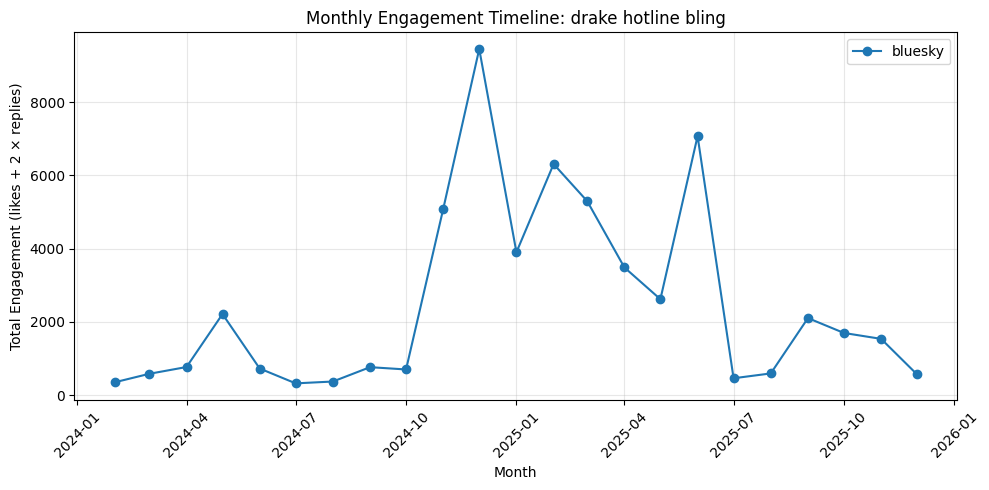

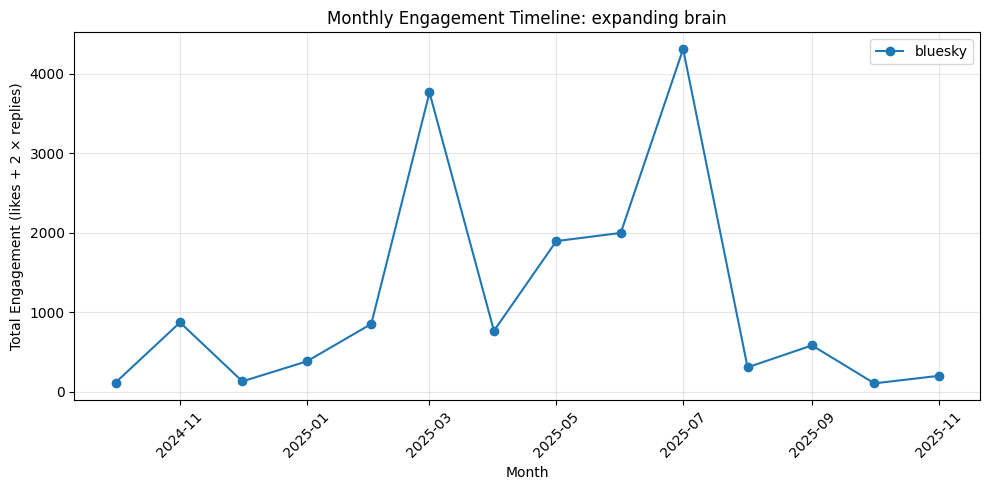

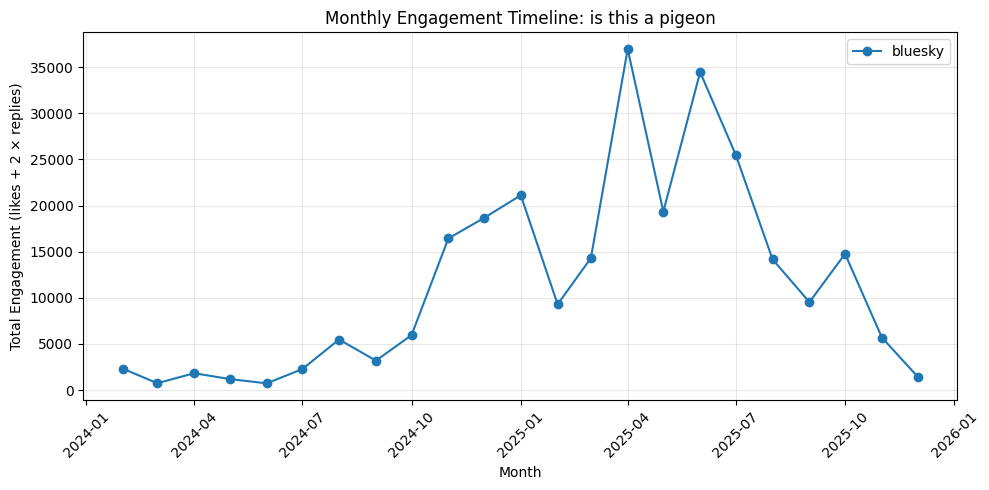

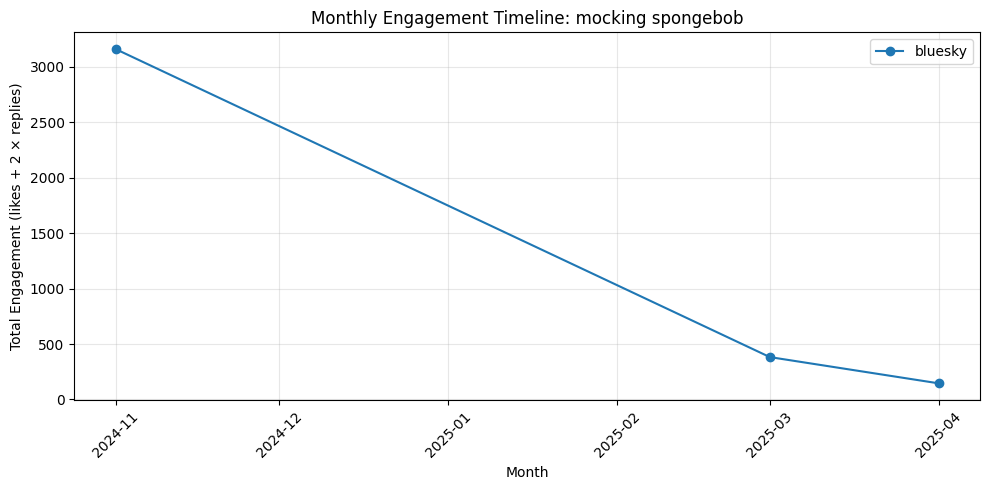

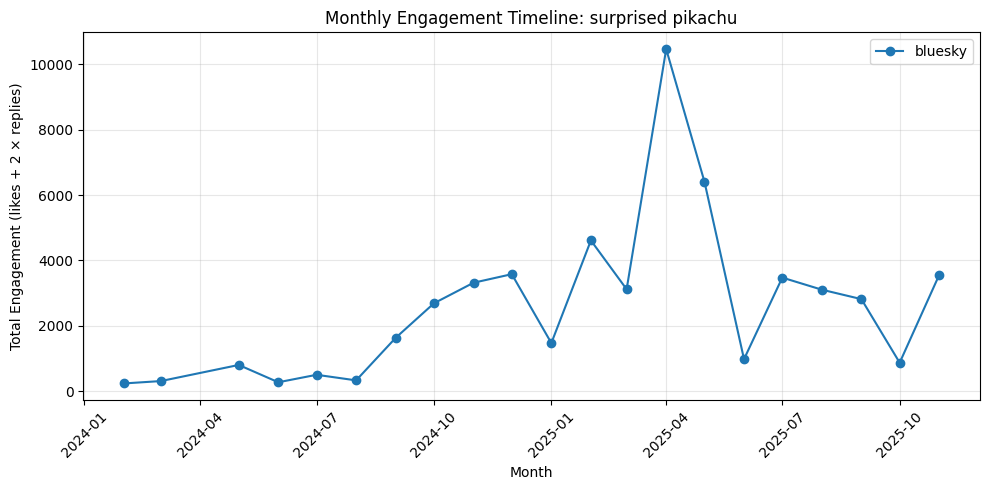

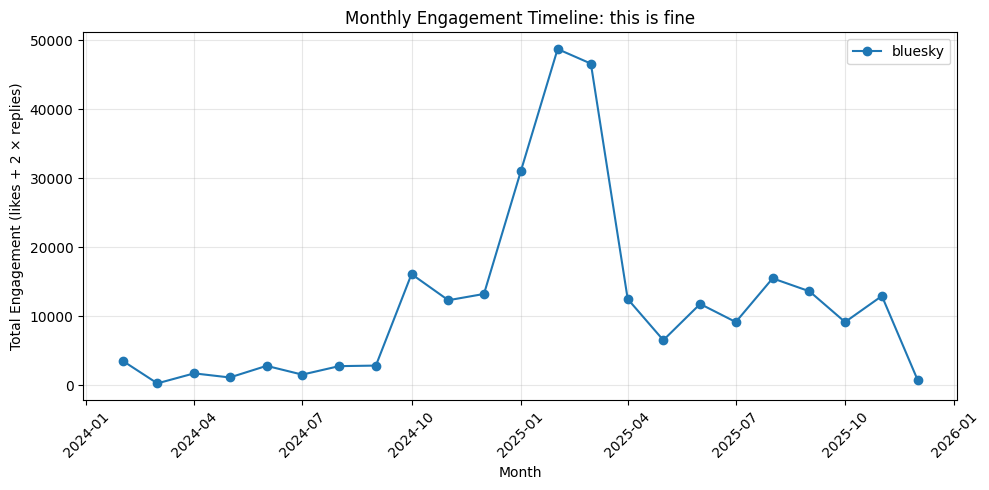

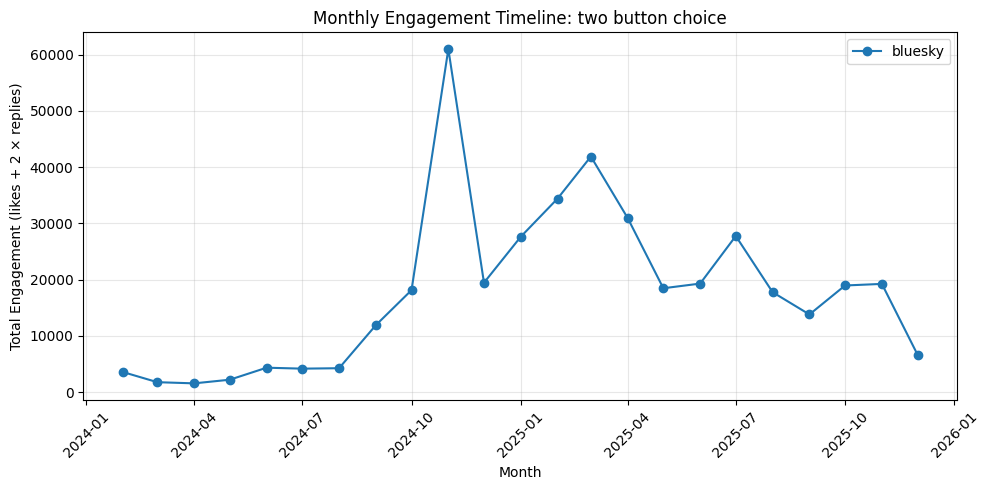

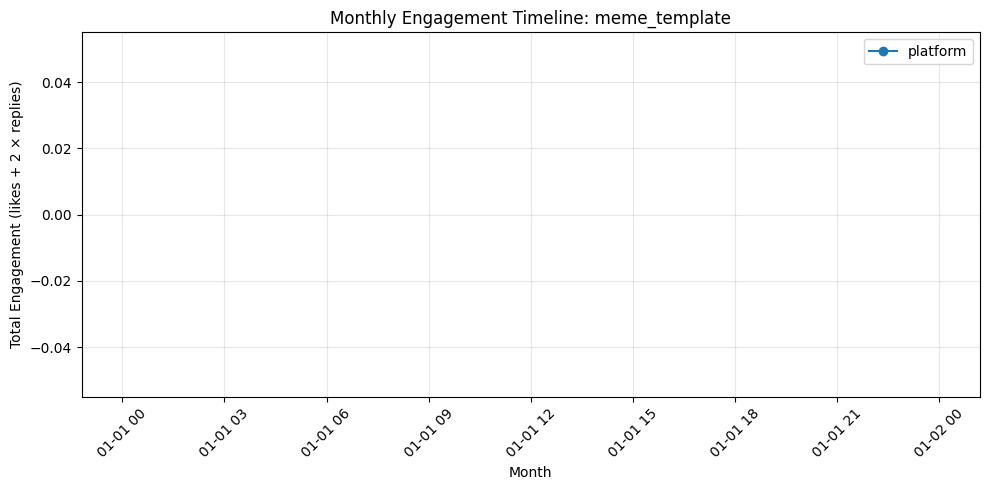

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your monthly summary file
monthly = pd.read_csv("monthly_template_summary.csv")

# Ensure month is sorted correctly
monthly["month"] = pd.to_datetime(monthly["month"])

# Get the unique templates
templates = monthly["meme_template"].unique()

# Loop through templates and create a plot for each one
for template in templates:
    subset = monthly[monthly["meme_template"] == template].sort_values("month")

    plt.figure(figsize=(10, 5))

    # Plot separately for each platform
    for platform in subset["platform"].unique():
        platform_data = subset[subset["platform"] == platform]
        plt.plot(
            platform_data["month"],
            platform_data["total_engagement"],
            marker="o",
            label=platform,
        )

    plt.title(f"Monthly Engagement Timeline: {template}")
    plt.xlabel("Month")
    plt.ylabel("Total Engagement (likes + 2 × replies)")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Save each figure
    plt.savefig(f"timeline_{template.replace(' ', '_')}.png", dpi=300)

    plt.show()



## 12. Limitations and ethical considerations

In this markdown cell, discuss:

- Sampling biases (which subreddits / hashtags you used)  
- API limitations (rate limits, deleted posts, etc.)  
- Representativeness of Reddit and Bluesky users  
- Potential ethical issues (e.g., sensitive content, privacy)  
- Constraints of using automated sentiment / framing models on memes



## 13. Summary and link to paper

Summarize the main findings that this notebook reproduces, in a few bullet points:

- How visual templates relate to virality  
- How caption framing and sentiment relate to virality  
- Key differences between Reddit and Bluesky  

Reference the corresponding sections / figures in your paper so graders can easily cross-check.
